In [1]:
import miner2
import miner2.preprocess
import miner2.coexpression
import miner2.mechanistic_inference
import pandas as pd
import os
import matplotlib.pyplot as plt 
import math
import seaborn as sns
import scipy
import numpy as np
import miner2.miner

%matplotlib inline

2019-08-08 16:16:10 	 hello from miner2 version 0.0.9


In [3]:
# import data
df = pd.read_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/results/expected/GSM3587977_AML707B-D97.dem.txt', sep='\t', header = 0, index_col = 0, engine='python')

# filter out mRNA and rRNA  and ncRNA genes
# by dropping out gene rows
df = df.drop(index = ['MTRNR2', 'RNA28S', 'RNA18S', 'MALAT1'])

# scale factor such that each cell has 10,000 reads
# get sum of reads for each individual cell
sums = df.sum(axis = 0)
scaleFactor = 10000 / sums

for single_cell in df.columns:
    df[single_cell] = df[single_cell].apply(lambda x: x * scaleFactor[single_cell])
    
# log2 + 1 operation
df = df.applymap(lambda x: math.log2(x + 1))

df

,AML707B-D97_AAAAGGCTGAGA,AML707B-D97_AACTTTGTGCCG,AML707B-D97_AATTGAGTGCTN,AML707B-D97_ACACTTGACTAA,AML707B-D97_ACCCGCGAAGAC,AML707B-D97_ACCGTCTTTGAC,AML707B-D97_ACTAGATTCGAG,AML707B-D97_ACTATTCAACGG,AML707B-D97_ACTTAGTCGGTC,AML707B-D97_AGAGATTGACAG,...,AML707B-D97_TTGTGTGACTGN,AML707B-D97_AACCAACTGACC,AML707B-D97_GATTTATATTGC,AML707B-D97_GTAATGGCGGAT,AML707B-D97_CACGATGGGTTG,AML707B-D97_CGCCCGTAGGTG,AML707B-D97_CTCGGACTGATN,AML707B-D97_GTTGAACCGGAN,AML707B-D97_CGGCAACATCGN,AML707B-D97_GGCTCAATAATA
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,2.787263,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,3.487294,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A1BG-AS1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A1CF,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A2M,0.000000,0.000000,0.0,0.000000,2.12216,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A2M-AS1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A2ML1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A2MP1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A3GALT2,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
A4GALT,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [20]:
# calculate mean and std dev across each gene
dfMean = df.mean(axis = 1)
dfStdDev = df.std(axis = 1)

# sort by descending order for each gene
dfMean = dfMean.sort_values(ascending = False)
dfStdDev = dfStdDev.sort_values(ascending = False)

# remove genes where mean <= mean_threshold or std_dev <= stddev_threshold
mean_threshold = 0
stddev_threshold = 0

print('genes before filter out mean <= {} and std_dev <= {}: {}'.format(mean_threshold, stddev_threshold, df.shape))

# filter out genes where mean <= mean_threshold or std_dev <= stddev_threshold
dfMean = dfMean[dfMean > mean_threshold]
dfStdDev = dfStdDev[dfStdDev > stddev_threshold]

dfFiltered = df.loc[dfMean.index & dfStdDev.index]

print('genes after filter out mean <= {} and std_dev <= {}: {}'.format(mean_threshold, stddev_threshold, dfFiltered.shape))

genes before filter out mean <= 0 and std_dev <= 0: (27895, 84)
genes after filter out mean <= 0 and std_dev <= 0: (11194, 84)


In [21]:
percentage_threshold = 0.2
expression_threshold = 1

print('genes before filter out by at least {}% above {}: {}'.format(percentage_threshold * 100, expression_threshold, dfFiltered.shape))

min_number_of_genes_greater_than_threshold = percentage_threshold * dfFiltered.shape[1]
indices = []
# filter out genes, at least percentage_threshold genes need to have expression values greater than expression_threshold
for index, row in dfFiltered.iterrows():
    temp = row[row > expression_threshold]
    if temp.size >= min_number_of_genes_greater_than_threshold:
        indices.append(index) # add gene to list of genes that passed filtering test
        
dfFiltered = dfFiltered.loc[indices]
        
print('genes after filter out by at least {}% above {}: {}'.format(percentage_threshold * 100, expression_threshold, dfFiltered.shape))

genes before filter out by at least 20.0% above 1: (11194, 84)
genes after filter out by at least 20.0% above 1: (1023, 84)


In [7]:
def entropy(vector):
    data = np.array(vector)
    #hist = np.histogram(data,bins=50)[0b]
    bins = np.linspace(minVal,maxVal,50)
    hist = np.histogram(data,bins=bins)[0]
    length = len(hist)

    if length <= 1:
        return 0

    counts = np.bincount(hist)
    probs = [float(i)/length for i in counts]
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    ent = 0.
    # Compute standard entropy.
    for i in probs:
        if i >0:
            ent -= float(i)*np.log(i)
    return ent

In [ ]:
entropy_threshold = 0.6

print('genes before filter out by entropy >= {}: {}'.format(entropy_threshold, dfFiltered.shape))

entropyVals = dfFiltered.apply(entropy, axis=1)
dfFiltered = dfFiltered.loc[entropyVals[entropyVals > entropy_threshold].index]

print('genes after filter out by entropy >= {}: {}'.format(entropy_threshold, dfFiltered.shape))

In [ ]:
min(entropyVals)

In [ ]:
# generate cumulative frequency graph of means and std devs
cumfreqBefore = scipy.stats.cumfreq(dfMean, numbins = 100)
x = cumfreqBefore.lowerlimit + np.linspace(0, cumfreqBefore.binsize*cumfreqBefore.cumcount.size, cumfreqBefore.cumcount.size)

plt.title('Cumulative Frequency Means, mean > 0.5 and stddev > 0.5')
plt.bar(x, cumfreqBefore.cumcount)
plt.show()
plt.tight_layout()
plt.savefig('./graphs/cumfreq_05_05')

In [ ]:
plt.xlabel('mean')
plt.ylabel('genes')
plt.title('mean distribution, mean > 0.1 and stddev > 0.1')
plt.hist(dfMean)
plt.tight_layout()
#plt.savefig('./graphs/01_01_means')

In [ ]:
plt.xlabel('std dev')
plt.ylabel('genes')
plt.hist(dfStdDev)
plt.tight_layout()
#plt.savefig('./graphs/01_01_stddevs')

In [ ]:
# get 50 most expressed genes (by mean) and plot heatmap

mostExpressedGenesDf = dfFiltered.loc[dfFiltered.head(50).index]
heatmap = sns.heatmap(mostExpressedGenesDf)
heatmap.set_title('Top 50 genes expressed: 50% over 0.7')
# heatmap.get_figure().savefig('./graphs/heatmap01')

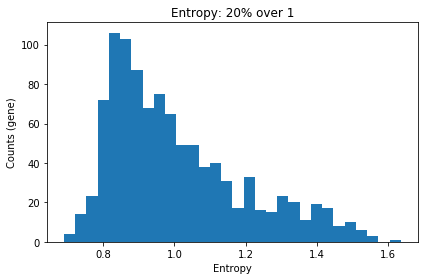

In [22]:
minVal = min(dfFiltered.values.flatten())
maxVal = max(dfFiltered.values.flatten())
entropyVals = dfFiltered.apply(entropy, axis=1)

# compiledFPKM = entropyVals.values.tolist()
# tempList = []

# for element in compiledFPKM:
#     tempList.append(item)

plt.hist(entropyVals, bins = 30)
plt.title("Entropy: 20% over 1")
plt.ylabel("Counts (gene)")
plt.xlabel("Entropy")
plt.tight_layout()
plt.savefig('./graphs/new_entropy05')
# plt.ylim(0,1000)

In [ ]:
entropyVals[entropyVals > 0.20]

In [ ]:
# graph all expression data
all_values = dfFiltered.values.flatten()
plt.hist(all_values, bins = 20)
plt.title("All Gene Expression Values - 20% over 2")
plt.ylabel("Counts (genes)")
plt.xlabel("Gene Expression")
plt.tight_layout()
plt.savefig('./graphs/allvals05')